# Проект &laquo;Русская поэзия&raquo;

Вам предстоит проанализировать датасет `russian_poetry.csv`, расположенный в той же папке, что и данный блокнот.

В качестве результата необходимо загрузить данный файл `project.ipynb` на Яндекс.Диск, открыть к нему общий доступ и приложить ссылку в качестве ответа в ЛМС.


Для решения задачи вы можете использовать любые подходящие библиотеки Python из числа тех, которые можно установить с помощью команды `pip install`.

**Важно**. Данная задача будет проверяться вручную. Постарайтесь аккуратно оформлять исходный код вашего решения, при необходимости сопровождая его комментариями.

## Подготовка к работе
Здесь написаны команды для установки библиотек Python, используемых в работе. ВНИМАНИЕ! Нет гарантии корректной установки пакетов в среде Jupyter. После установки пакетов

In [220]:
# pip install pandas numpy pymorphy2 pymorphy2-dicts-ru joblib tqdm wordcloud matplotlib requests

In [221]:
%pip install pandas numpy pymorphy2 pymorphy2-dicts-ru joblib tqdm matplotlib wordcloud requests

Defaulting to user installation because normal site-packages is not writeable
Note: you may need to restart the kernel to use updated packages.


You should consider upgrading via the 'c:\program files\python\python.exe -m pip install --upgrade pip' command.


## Открытие и первичная обработка датасета

In [223]:
import pandas as pd
import numpy as np
from tqdm.notebook import tqdm
from joblib import Parallel, delayed
from string import punctuation
from pymorphy2 import MorphAnalyzer
from collections import Counter
from wordcloud import WordCloud
import matplotlib.pyplot as plt
from requests import get
%matplotlib inline

punctuation += ' «»—'
morph = MorphAnalyzer()
SERVICE_POS = {"PREP", "CONJ", "PRCL", "INTJ"}  # служебные части речи -> не будут учитываться при сздании облака всех слов
data = pd.read_csv("./russian_poetry.csv")
tqdm.pandas()

In [224]:
# В датасете есть записи с одинаковыми стихотворениями, поэту нужно удалить дупликаты
# Но в разных записях содержатся разная информация о стихоторении (где-то  указано название, где-то нет и т.п),
# поэтму нужно сохраниь всю полезную информацию для каждого стихотворения из дупликатов
dupl = data[data.duplicated(subset=["text"], keep=False) == True]
# ffil и bfill заполонят все NaN в записях на полезную информацию, если эта информация есть хоть в одной записи повторяющихся стихотворений
dupl = dupl.groupby("text", group_keys=False).apply(lambda x: x.ffill().bfill()).drop_duplicates(subset="text")
# удалим все дупликаты из изначального датасета и обновим его из созданной ранее группы
data = data.drop_duplicates(subset="text")
data.combine_first(dupl)
# обновим индексы и замним нулевые значения на NaN
data = data.reset_index().fillna(value=np.nan)
# если у стихотворения в датасете отсутствует название, примем в качестве названия его первую строку
# смысл этого действия есть только в том случае, когда мы хотим получить название стиха, а его нет
data["name"].fillna(value=data['text'].apply(lambda x: x.split('\r\n')[0].strip(punctuation)), inplace=True)

In [226]:
def check_input_data(x):
    """возвращает объединенный текст в заивсимости от типа аргумента"""
    if isinstance(x, tuple):
        return '\r\n'.join(x[1]["text"])
    elif isinstance(x, pd.DataFrame):
        return '\r\n'.join(x["text"])
    elif isinstance(x, pd.Series):
        return x.get("text", '\r\n'.join(x))
    elif isinstance(x, str):
        return x

    
def get_all_words(x):
    # получим все слова стихов и уберем знаки препинания
    words = [j.strip(punctuation) for i in check_input_data(x).lower().split('\r\n') for j in i.split()]
    words = filter(lambda x: x != '' and x not in punctuation, words)
    morphed = {}
    for word in words:
        if word in morphed:
            morphed[word]["cnt"] = morphed[word]["cnt"] + 1
            continue
        parsed = morph.parse(word)[0]
        # для каждого слова сохраним его начальную форму, часть речи и будем считать, сколько раз оно встретилось в текстах 
        morphed[word] = {"form": parsed.normal_form, "pos": parsed.tag.POS, "cnt": 1}
    normal_forms = {}
    # "перевернем" словарь: для каждой начальной формы, полученной ранее, сохраним ее часть речи и количество в тексте (включая все формы)
    for key in morphed:
        form, pos, cnt = morphed[key]["form"], morphed[key]["pos"], morphed[key]["cnt"]
        normal_forms[form] = {"pos": pos, "cnt": normal_forms.get(form, {"cnt": 0})["cnt"] + cnt}
    return (x[0], normal_forms) if isinstance(x, tuple) else normal_forms


# для каждого поэта получим множество использующихся слов в его стихах (формы слова не считаются отдельными словами)
# ВНИМАНИЕ! ПОСТАНОВКА ВСЕХ СЛОВ В НАЧАЛЬНУЮ ФОРМУ ЗАНИМАЕТ ОКОЛО 1 МИНУТЫ
try:
    processed_texts = Parallel(n_jobs=-1)(delayed(get_all_words)(t) for t in tqdm(data.groupby("author")))
    words_dict = {}
    for i in processed_texts:
        words_dict[i[0]] = i[1]
    word_group = data.groupby("author").apply(lambda x: words_dict[x["author"].iloc[0]])
except UnicodeEncodeError:
    # библиотека для параллелизации может выдавать ошибку кодировки (не у всех)
    # если ошибка возникла, обработаем данные поледовательно
    word_group = data.groupby("author").progress_apply(get_all_words)

  0%|          | 0/195 [00:00<?, ?it/s]

## 1 Deep Dive: давайте посчитаем
<img src="1.png" width=300 align='right' hegith='200' hspace='100'> 

При работе с любыми данными вначале необходимо оценить их содержательный объём. 

Наш датасет описывает поэтов и их произведения.

Постараемся ответить на несколько простых вопросов:
- Сколько поэтов в датасете
- Сколько стихотворений в датасете
- Сколько в среднем стихотворений на одного поэта

### Сколько поэтов в датасете?

In [227]:
data["author"].nunique()

195

### Сколько стихотворений в датасете?

In [228]:
data["text"].count()

16411

### Сколько в среднем стихотворений на одного поэта?

In [229]:
data.groupby("author")["text"].count().mean()

84.15897435897436

## 2 О поэтах 
<img src="2.png" width=300 hegith='200' align='right' border="50"> 

Рассмотрим информацию о поэтах, найдем всех рекордсменов:
 - Кто написал больше всех стихотворений?
 - Кто написал самое короткое и самое длинное стихотворение?
 - Кто творил дольше остальных (найдите разницу в годах между первым и последним написанным стихотворением для  каждого автора)
 - У кого из поэтов самая короткая карьера?
 - Какое имя наиболее часто встречается среди поэтов?
 - У кого из поэтов самый богатый словарный запас?

### Кто написал больше всех стихотворений?

In [230]:
data.groupby("author")["text"].count().idxmax()

'Владимир Высоцкий'

### Кто написал самое короткое и самое длинное стихотворение?

In [231]:
idx_min, idx_max = data["text"].str.len().idxmin(), data["text"].str.len().idxmax()
', '.join(data.iloc[[idx_min, idx_max]]["author"])

'Велимир Хлебников, Николай Некрасов'

### Кто творил дольше остальных?
 
Найдите разницу в годах между первым и последним написанным стихотворением для каждого автора

In [232]:
group = data.groupby("author").apply(lambda x: x["date_to"].max() - x["date_from"].min())
group.idxmax()

'Федор Тютчев'

### У кого из поэтов самая короткая карьера?

In [233]:
group.idxmin()

'Александр Кочетков'

### Какое имя наиболее часто встречается среди поэтов?

In [234]:
c = Counter(list(map(lambda x: x.split()[0], data["author"].unique())))
', '.join([i for i in c if c[i] == max(c.values())])

'Николай, Александр'

### У кого из поэтов самый богатый словарный запас?

In [235]:
word_group.apply(lambda x: len(set(x))).idxmax()

'Владимир Высоцкий'

## 3 О стихах
<img src="3.png" width=300 height='200' align='right' border="50"> 
&nbsp;

Углубимся в тексты.

- Самое первое стихотворение в этом датасете?
- Самое последнее стихотворение?
- Самое короткое и самое длинное стихотворение?
- Какое произведение писали дольше всех остальных?
- Самое популярное слово?
- Средний размер стихотворения в словах и в строках?

### Самое первое стихотворение в этом датасете? 

Стихотворение, написанное в первый год, доступный в датасете. Если таковых несколько, укажите их все.

In [236]:
', '.join(list(data[data["date_to"] == data["date_to"].min()]["name"]))

'Элегия о смерти Петра Великого'

### Самое последнее стихотворение?

Стихотворение, написанное в последний год, доступный в датасете. Если таковых несколько, укажите их все.

In [237]:
', '.join(list(data[data["date_to"] == data["date_to"].max()]["name"]))

'Молитва'

### Самое короткое и самое длинное стихотворение?

In [238]:
'; '.join(data.iloc[[idx_min, idx_max]]["name"])

'Очи Оки; Мороз, Красный нос'

### Какое произведение писали дольше всех остальных?

In [239]:
data.iloc[(data["date_to"] - data["date_from"]).idxmax()]["name"]

'Разлука'

### Самое популярное слово?

Найдите самое популярное существительное, не являющееся служебной частью речи.

In [240]:
def get_words_by_pos(pos=None, author=None):
    """возвращает все слова определенной части речи"""
    if author is None:
        if pos is not None:
            return word_group.apply(lambda x: {i: x[i]["cnt"] for i in x if x[i]["pos"] == pos})
        return word_group.apply(lambda x: {i: x[i]["cnt"] for i in x if x[i]["pos"] not in SERVICE_POS})
    words = word_group[author]
    if pos is not None:
        return {i: words[i]["cnt"] for i in words if words[i]["pos"] == pos}
    return {i: words[i]["cnt"] for i in words if words[i]["pos"] not in SERVICE_POS}

def merge_dicts(dicts):
    """функция слияния словарей работает по принципу метода update класса Counter: 
    результирующий словарь по ключу содержит сумму значений всех словарей по тому же ключу"""
    res_dict = {}
    for d in dicts:
        for key in d:
            res_dict[key] = res_dict.get(key, 0) + d[key]
    return res_dict


# создадим счётчик всех существительных
c = Counter(merge_dicts(get_words_by_pos("NOUN")))
# получим самое часто встречающееся
c.most_common(1)[0][0]

'день'

### Средний размер стихотворения в словах и в строках?

In [241]:
average_lines = data["text"].apply(lambda x: len(x.split('\r\n'))).mean()
average_words = data["text"].apply(lambda x: len([j for i in x.split('\r\n') for j in i.split() if j and j not in punctuation])).mean()
f"{average_words}, {average_lines}"

'128.77527268295654, 29.33855340929864'

## 4 Вопросы со звездочкой

<img src="4.png" width=300 hegith='200' align='right' border="50"> 

- В какой год писалось наибольшее количество стихотворений (было написано или находилось в процессе создания)
- Облако слов. Изучите библиотеку [wordcloud](https://pypi.org/project/wordcloud), отфильтруйте топ существительных и постройте облако слов
- Разбейте весь датасет на эпохи (Первая половина 19 века, Вторая половина 19 века, 20 век). Сравните в количественном и качественном составе, чем отличаются произведения этих эпох. 
- В какую эпоху писалось больше стихотворений?
- Менялась ли самая популярная тема по эпохам?
- Облака слов по эпохам
- Сравните облака слов Пушкина и Высоцкого

### В какой год писалось наибольшее количество стихотворений?

Под "писалось" понимается "было написано или находилось в процессе создания в течение этого года"

In [242]:
# заведем счетчик стихов
# год в поле date_from означает, что общее количество пишущихся в момент стихов нужно увеличить на 1
# год в поле date_to означает, что общее количество пишушихся стихов нужно уменьшить на 1, причем уменьшить со следующего года
# (так как в рассматриваемый год оно было обупликовано, что удовлетворяет условию "было написано")
froms = map(lambda x: (x, 1), data[~data["date_from"].isna()]["date_from"])
tos = map(lambda x: (x + 1, -1), data[~data["date_to"].isna()]["date_to"])
years = sorted(list(froms) + list(tos))
c = 0
max_ = 0
max_year = None
# решим задачу динамически
for idx, i in enumerate(years):
    if i[1] == 1:
        c += 1
    else:
        # если в прошлом году какой-то стих был опубликован, проверим, максимальное ли количество стихов писалось в том году 
        if c > max_:
            max_ = c
            max_year = years[idx - 1][0]
        c = 0
int(max_year)

1916

### Облако слов

Изучите библиотеку [wordcloud](https://pypi.org/project/wordcloud), отфильтруйте топ существительных и постройте облако слов

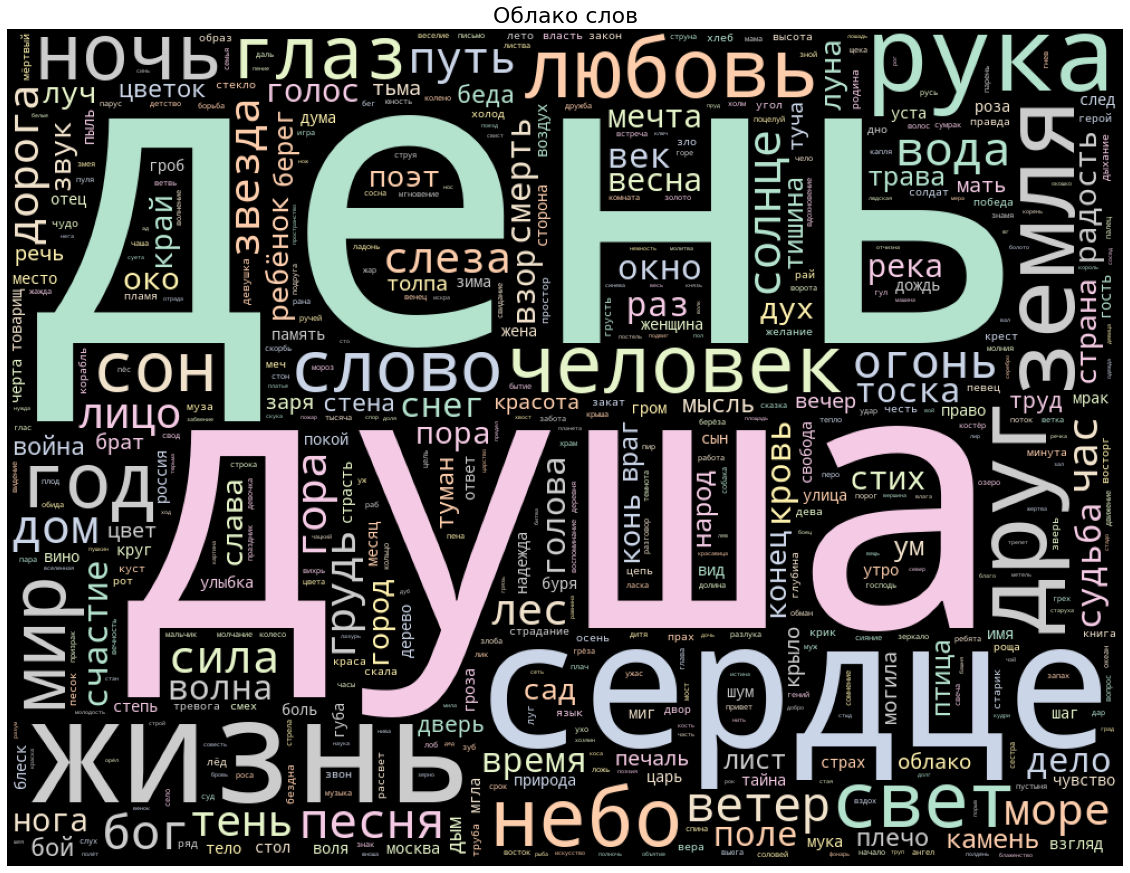

In [243]:
def show_cloud(wordcloud, label="Облако слов"):
    """Отрисовка облака"""
    plt.figure(figsize=(20, 20))
    plt.title(label, fontdict={"fontsize": 22})
    plt.imshow(wordcloud) 
    plt.axis("off")
    

def get_cloud(text):
    cloud = WordCloud(
        width=1000, height=750, random_state=1, max_words=500, background_color='black', margin=10, colormap='Pastel2'
    ).generate_from_frequencies(text)
    return cloud
    

show_cloud(get_cloud(merge_dicts(get_words_by_pos(pos="NOUN"))))

### Эпохи 

Разбейте датасет на эпохи (Первая половина 19 века, Вторая половина 19 века, 20 век). Сравните в количественном и качественном составе, чем отличаются произведения этих эпох.

In [244]:
def check_in_period(date_from, date_to, left, right):
    """Проверка на вхождение в эпоху. Считается, что стих входит в эпоху, если минимум половина времени между
    date_to и date_from входит в период"""
    years = range(int(date_from), int(date_to) + 1)
    intersect = len([i for i in years if i in range(left, right + 1)])
    return intersect != 0 and intersect >= len(years) // 2


df = data[(~data["date_from"].isna()) & (~data["date_to"].isna())]
century19_1 = df[df.apply(lambda x: check_in_period(x["date_from"], x["date_to"], 1800, 1849), axis=1)]
century19_2 = df[df.apply(lambda x: check_in_period(x["date_from"], x["date_to"], 1850, 1899), axis=1)]
century20 = df[df.apply(lambda x: check_in_period(x["date_from"], x["date_to"], 1900, 1999), axis=1)]


### В какую эпоху писалось больше стихотворений?

In [245]:
cnt19_1, cnt19_2, cnt20 = century19_1["text"].count(), century19_2["text"].count(), century20["text"].count()
max_ = max(cnt19_1, cnt19_2, cnt20)
if cnt19_1 == max_:
    answer = "Первая половина XIX века"
elif cnt19_2 == max_:
    answer = "Вторая половина XIX века"
else:
    answer = "XX век"
answer

'XX век'

### Менялась ли самая популярная тема по эпохам?

In [246]:
# так как количество тем для всех эпох, записанных в themes/item/0, значительно превышает количество тем в остальных полях тем,
# то будем сравнивать сравнивать наиболее популярные темы в themes/item/0
main_theme_19_1 = century19_1[~century19_1["themes/item/0"].isna()]["themes/item/0"].mode()[0]
main_theme_19_2 = century19_2[~century19_2["themes/item/0"].isna()]["themes/item/0"].mode()[0]
main_theme_20 = century20[~century20["themes/item/0"].isna()]["themes/item/0"].mode()[0]
if main_theme_19_1 == main_theme_19_2 == main_theme_20:
    answer = f"Нет. Наиболее популярная тема на протяжении всего времени - {main_theme_19_1}"
else:
    answer = f"Да. Наиболее популярные темы по эпохам: {main_theme_19_1}, {main_theme_19_2}, {main_theme_20}"
answer

'Нет. Наиболее популярная тема на протяжении всего времени - О любви'

### Облака слов по эпохам

Разделите облака слов по эпохам и постройте для каждой эпохи своё облако.

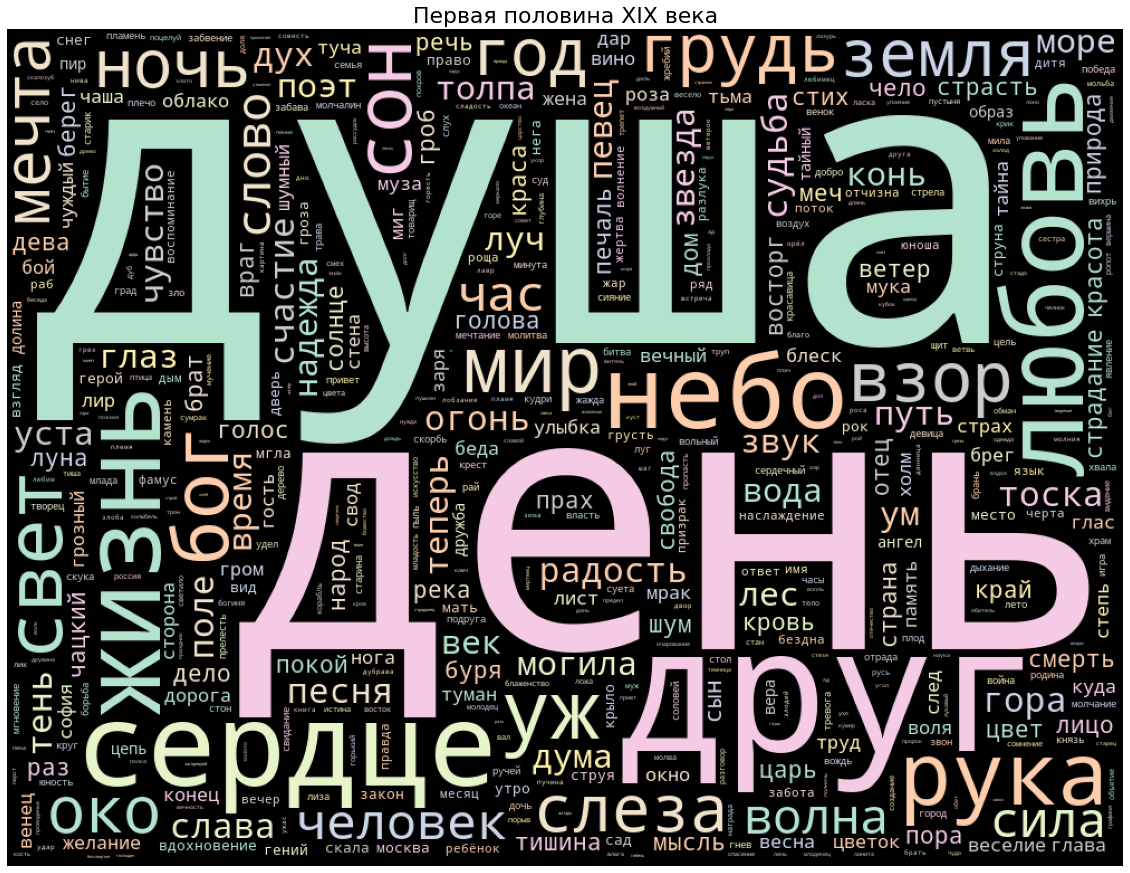

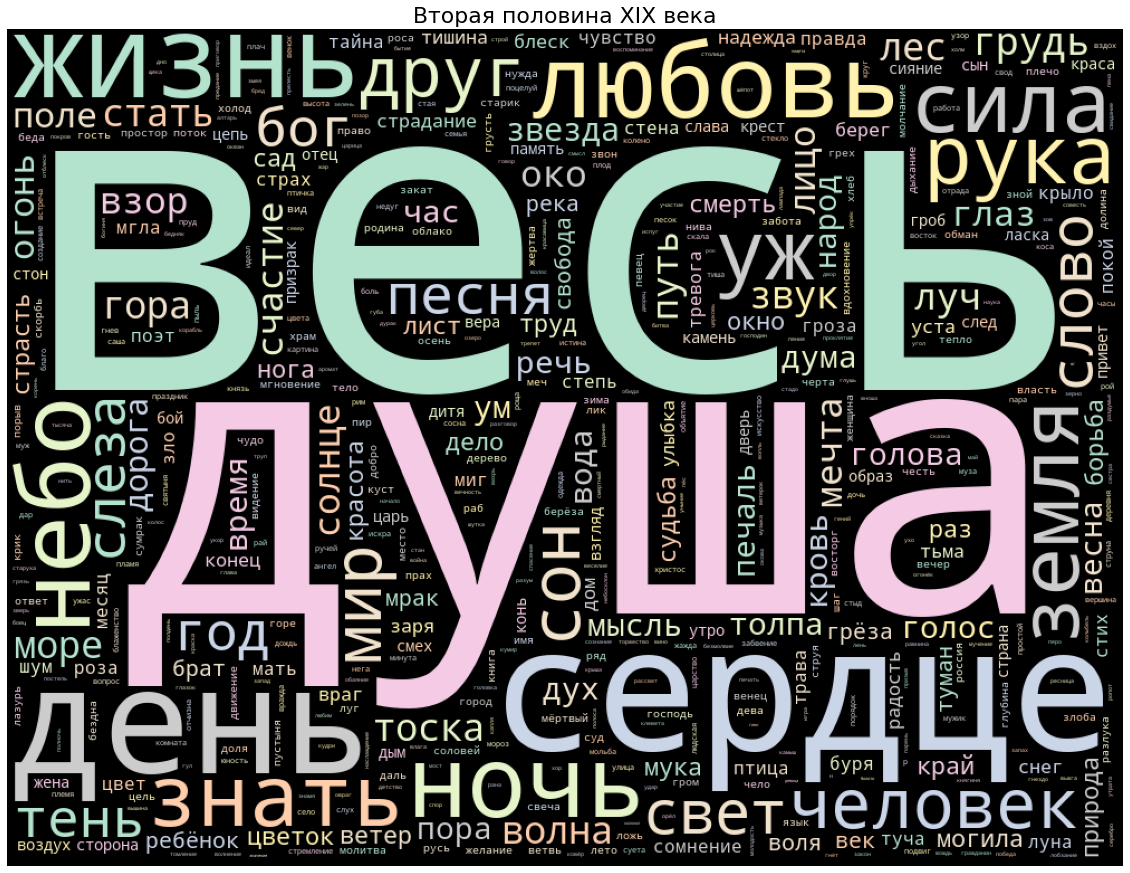

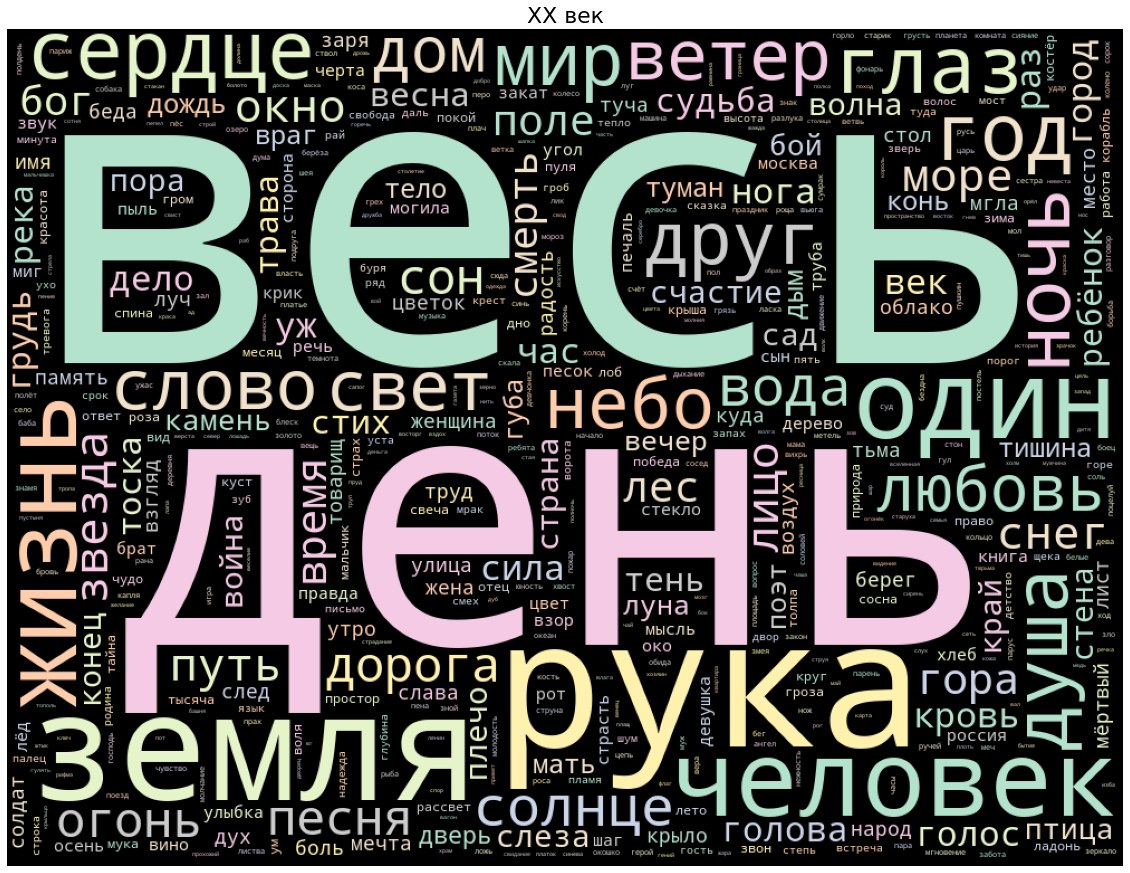

In [248]:
def get_frequencies_from_group(group, pos=None):
    if pos is not None:
        return {i: group[i]["cnt"] for i in group if group[i]["pos"] == pos}
    return {i: group[i]["cnt"] for i in group if group[i]["pos"] not in SERVICE_POS}


words19_1 = get_all_words(century19_1["text"])
words19_2 = get_all_words(century19_2["text"])
words20 = get_all_words(century20["text"])
cloud_pos = "NOUN"
show_cloud(get_cloud(get_frequencies_from_group(words19_1, cloud_pos)), label="Первая половина XIX века")
show_cloud(get_cloud(get_frequencies_from_group(words19_2, cloud_pos)), label="Вторая половина XIX века")
show_cloud(get_cloud(get_frequencies_from_group(words20, cloud_pos)), label="XX век")

### Сравните облака слов Пушкина и Высоцкого

'Как мы можем заметить, облака слов двух поэтов имеют много общего. Например, вот самые популярные общие слова: день, сон, душа, вода, конь, свет, глаз, жизнь, друг, год, ночь, рука, бог'

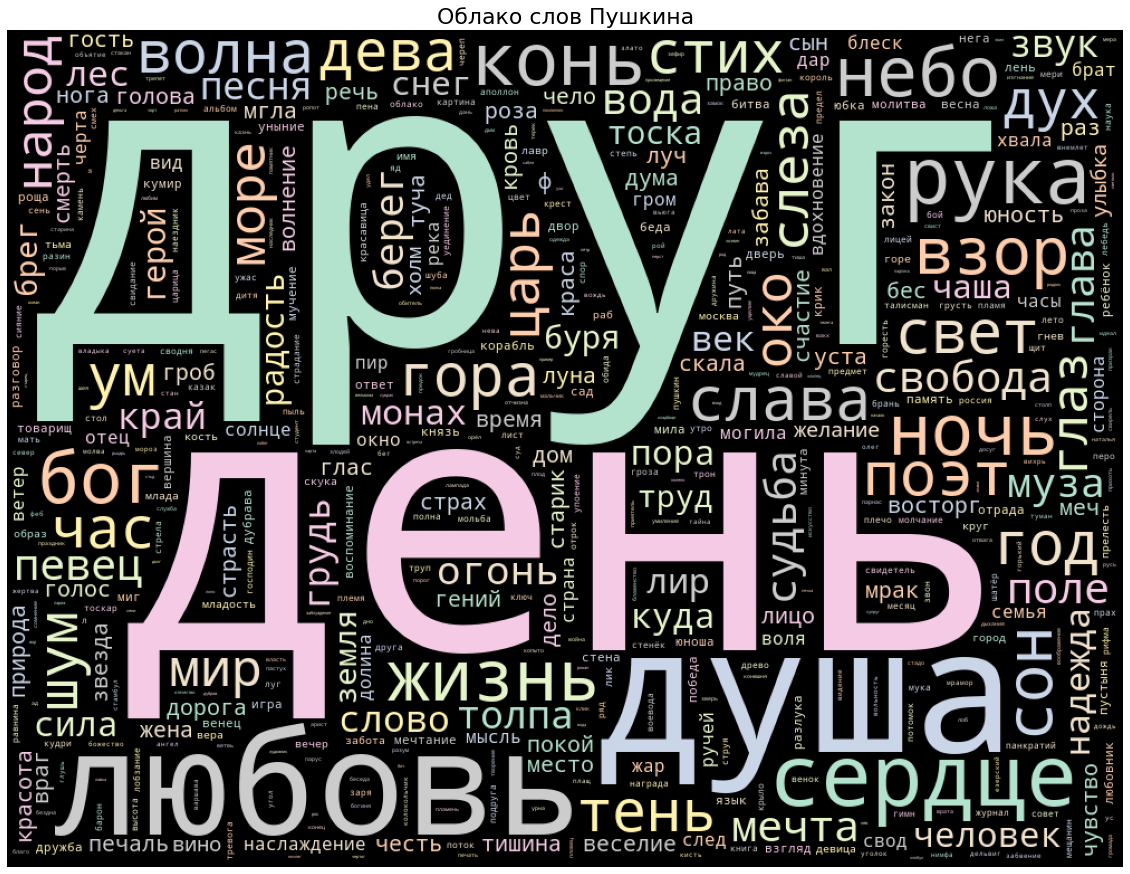

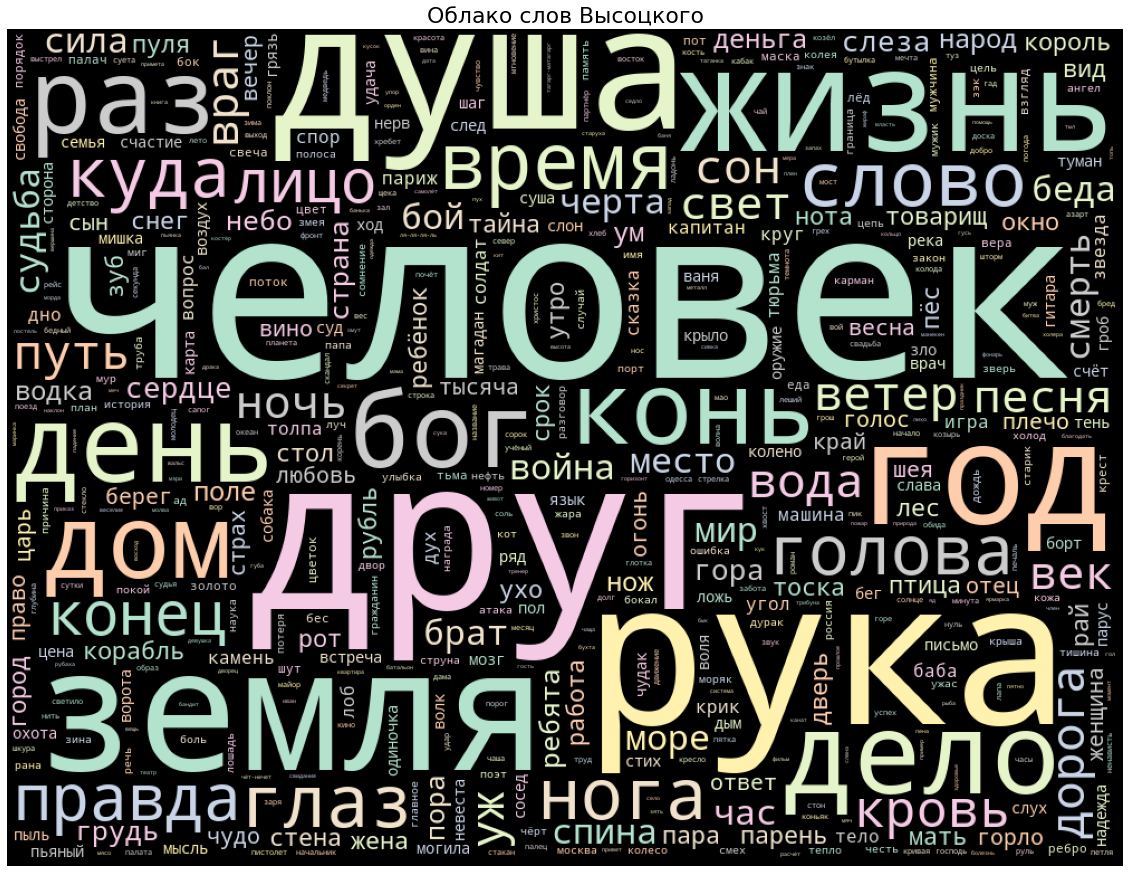

In [249]:
pos_argument = "NOUN"
words1 = get_words_by_pos(pos=pos_argument, author="Александр Пушкин")
words2 = get_words_by_pos(pos=pos_argument, author="Владимир Высоцкий")
show_cloud(get_cloud(words1), label="Облако слов Пушкина")
show_cloud(get_cloud(words2), label="Облако слов Высоцкого")

num = 40
most_common1 = sorted(words1, key=lambda x: words1[x], reverse=True)[:num]
most_common2 = sorted(words2, key=lambda x: words2[x], reverse=True)[:num]
intersect_words = set(most_common1) & set(most_common2)
if not intersect_words:
    anwser = "Как мы можем заметить, у поэтов нет ничего общего"
else:
    answer = f"Как мы можем заметить, облака слов двух поэтов имеют много общего. Например, вот самые популярные общие слова: {', '.join(intersect_words)}"
answer

## 5 Свободное плавание
<img src="5.png" width=300 hegith='200' align='right' border="50"> 
&nbsp;

Мы пробежались по основым моментам этого датасета. 

Возможно, вы подметили что-то ещё, что ускользнуло от нашего взгляда. 

Постарайте привести как можно больше дополнительных интересных фактов, которые вы можете найти в этом датасете. 

Каждый такой факт (или вопрос, на который вы отвечали), оформите в виде отдельной ячейки в данном блокноте, по аналогии с предыдущими пунктами.

P.S. Иллюстрации для проекта любезно сгенерированы нейросетью MidJourney

## Как в стихах поэтов отражаются социальные потрясения, происходящие в государстве?
Посмотрим, как меняются стихи поэтов в тяжелые для страны времена. Будем следить за пиками использования слов, связанных с войнами, революциями и другими катастрофами.
Для получения ассоциаций к словам воспользуемся API https://wordassociations.net/ru/

  0%|          | 0/251 [00:00<?, ?it/s]

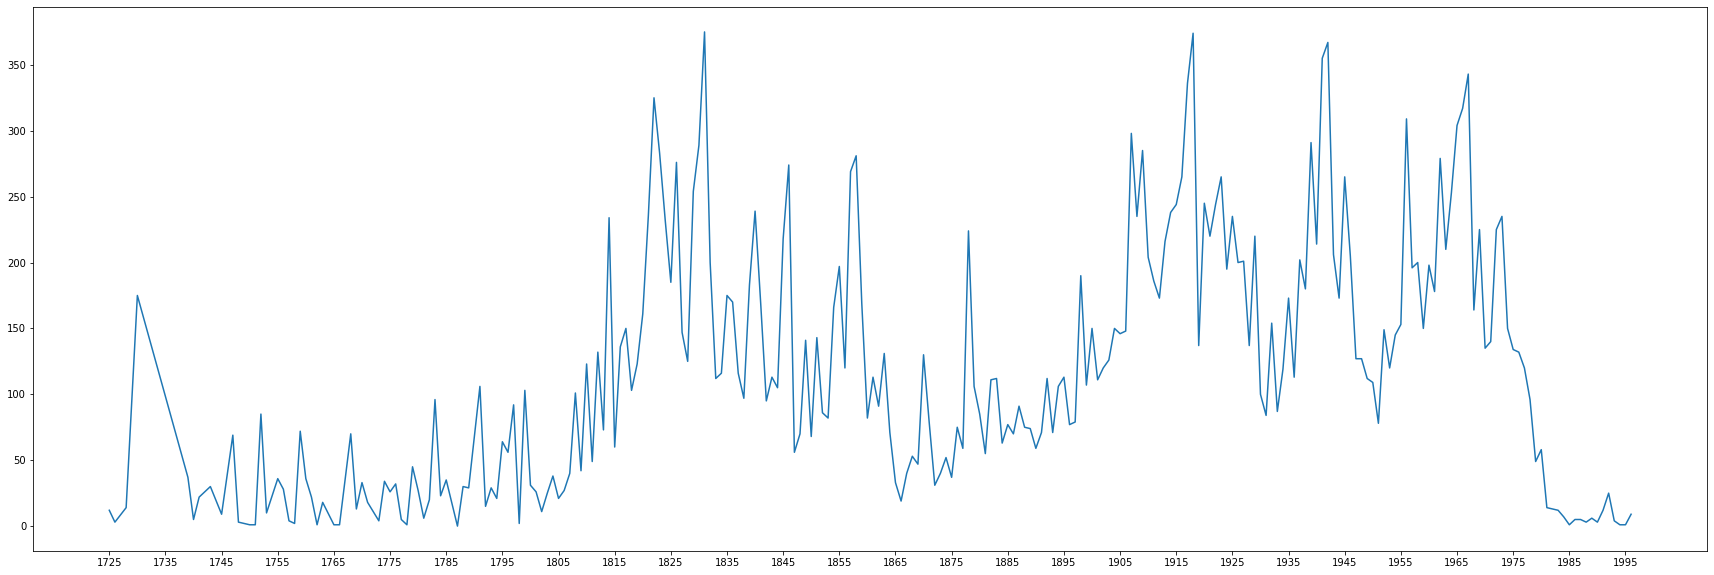

'Как можно заметить, поэзия активно откликается на перемены в обществе. Наибольшие пики использования слов характерны для восстанив в 1820-1830-е, Октябрьской революции и ее преддверия, Великой отечественной войны'

In [250]:
def get_associations(text):
    """получение ассоциаций"""
    url = "https://api.wordassociations.net/associations/v1.0/json/search?"
    params = {"apikey": "493bf9a9-1384-4350-a532-5ef0b167a62f", "text": text, 
              "lang": "ru", "type": "response", "pos": "noun,adjective,verb", "limit": 300}
    response = get(url, params=params)
    return {i["item"].lower() for i in response.json()["response"][0]["items"]}


associations = get_associations("война революция боль ужас катастрофа происшествие ад убийство гибель мрак")
years_group = data.groupby("date_from").progress_apply(get_all_words)
frequencies = years_group.apply(lambda x: sum([v["cnt"] for k, v in x.items() if k in associations]))
first_year, last_year = data["date_from"].min(), data["date_from"].max()
plt.figure(figsize=(30, 10))
plt.plot(frequencies)
plt.xticks(list(range(int(first_year), int(last_year), 10)))
plt.show()
result = "Как можно заметить, поэзия активно откликается на перемены в обществе. Наибольшие пики использования слов характерны для восстаний в 1820-1830-е, Октябрьской революции и ее преддверия, Великой отечественной войны"
result

## Выводы
- Проведена первичная обработка данных датасета (удалены дупликаты, данные от дупликатов совмещены и встроены в датасет)
- Все задания выполнены
- Придумано и решено одно собственное задание
- Получены навыки работы c Jupyter Notebook и библиотеками, предназначенными для анализа данных

## Замечания
- Постановка всех слов в начальную форму занимает немалое время
- При постановке слов в начальную форму не учитываются омоформы, из-за чего, например, в облаках эпох слово "весь" считается существительным (такое существительное действительно есть, но вовсе не факт, что оно использовалось чаще, чем такое же местоимение). Для большей точности требуется учитывание контекста, т.е. обработка естественного языка
- Непонятно, как считать карьеру поэтов, у которых максимальынй date_to позже, чем дата смерти

## Возможности для доработки
- Исправление всего, что написано в замечаниях
- Определение тем тех стихотворений, у которых в датасете нет тем
- Паралеллизация остальных вычислений